In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='P003':
    print('Not in /P003 folder, changing directory to P003')
    lib_path = os.path.expanduser(os.path.relpath('~/images/codesDIR/datathon2020/P003'))
    os.chdir(lib_path)

In [42]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch import optim

from torch.nn import MSELoss, L1Loss
# Neural network implementations: fcNet, diffNet
from src.nnets import get_model, train_model
from src import nnets
from src.utils import mse, lagged_xcorr

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,5)
# matplotlib.rcParams['font.size']= 22 # use for presentation


if torch.cuda.is_available():
    device = torch.device('cuda')
#     device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


In [46]:
import pandas as pd

pandas._libs.tslibs.timedeltas.Timedelta

In [67]:
T1 = pd.date_range(pd.to_datetime('2020-07-25 13:00:00'),pd.to_datetime('2020-07-30 00:00:00'),freq='H')+pd.Timedelta(minutes=11)
T2 = pd.date_range(pd.to_datetime('2020-07-25 13:00:00'),pd.to_datetime('2020-07-30 00:00:00'),freq='H')+pd.Timedelta(minutes=70)
T0 = pd.date_range(pd.to_datetime('2020-07-25 13:00:00'),pd.to_datetime('2020-07-30 00:00:00'),freq='H')
T18 = pd.date_range(pd.to_datetime('2020-07-25 13:00:00'),pd.to_datetime('2020-07-30 00:00:00'),freq='H')+pd.Timedelta(hours=18)

df = pd.DataFrame({'Ts':T1,'Tf':T2,'T(Energy)':T0,'T+18':T18})

In [74]:
pd.to_datetime('2020/07/26 18:00') - pd.Timedelta(hours=17)

Timestamp('2020-07-26 01:00:00')

In [73]:
pd.to_datetime('2020/07/26 18:00') - pd.Timedelta(hours=17) - pd.Timedelta(hours=8)

Timestamp('2020-07-25 17:00:00')

## Dataset Path and Persistence

In [4]:
with open('persistence_T18.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
lead_time = persistence['lead_time']
print('Persistence:',persistence)

Persistence: {'lead_time': 18, 'Persistence_Euclidean': 0.10196654967828511, 'Persistence_MSE': 0.20393309935657022, 'Persistence_MAE': 0.3105751548586914}


In [5]:
# Path for Datasets:
# all preprocessed data will be saved in `data_path`
data_path = os.path.relpath('../../../dataDIR/'+'preprocessed_linearinterp_avgmodels')
print(f'> Preprocessed data is from `{data_path}`\n')
# !ls $data_path

> Preprocessed data is from `../../../dataDIR/preprocessed_linearinterp_avgmodels`



- Clock: for `YXdifwind40_speedclock` 
```python
# datasets:
train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')
```
```python
# best diffnet:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1
```

- diff(Y,X) W=40, X(T+18),
```python
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
```

## Train

In [6]:
# Training and Testing data
train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print(f'Shapes\ntrain: {X_train.shape} {X_train.dtype},\ntest: {X_test.shape} {X_test.dtype}\n')

Shapes
train: torch.Size([29371, 370]) torch.float32,
test: torch.Size([1546, 370]) torch.float32



In [7]:
x = X_train[:,2:] # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1) #Y(T+0)
y = X_train[:,:1] # Y(T+lead_time)
print(f'(training) x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')

x_test = X_test[:,2:] # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1) #Y(T+0)
y_test = X_test[:,:1] # Y(T+lead_time)
print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')

train_ds = TensorDataset(x,Y0,y)
test_ds = TensorDataset(x_test,Y0_test,y_test)

(training) x torch.Size([29371, 368]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 368]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])



In [12]:
# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1

# Training parameters
batch_size = len(train_ds) # len(train_ds): single batch 
learning_rate = 0.001 # default for Adam
epochs = 220    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

In [29]:
model  = nnets.diffNet(input_dim=input_dim, layer_dims=layer_dims,
                       output_dim=1, dropout_p=dropout_p, acFn=nn.ReLU)
model.to(device)
opt = torch.optim.Adam(model.parameters(),lr=0.001)
# optim.SGD(model.parameters(), lr=lr)

In [42]:
train_dl = DataLoader(train_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=len(test_ds))

In [8]:
import glob,os
# location of networks
model_dir = os.path.relpath('./best_models')
# get all models that match the pattern:
model_filenames = glob.glob(os.path.join(model_dir,'24Jul2020*'))
# model_filenames = ['best_models/24Jul2020_0150_ver1.pkl']

In [9]:
import pickle
modellist = []
for fname in model_filenames:
    with open(fname, 'rb') as f:
        print(f'Loading {fname}')
        modellist.append(pickle.load(f))

for net in modellist:
    net.to(device)

def predictT18(x,y_0,nets=modellist):
    results = []
    y_0 = y_0.to(device)
    x = x.to(device)
    with torch.no_grad():
        for net in modellist:
            net.eval()
            results.append(net(x,y_0).detach().cpu().numpy())
    return results

Loading best_models/24Jul2020_0150_ver1.pkl
Loading best_models/24Jul2020_0150_ver5.pkl
Loading best_models/24Jul2020_0150_ver4.pkl
Loading best_models/24Jul2020_0150_ver2.pkl
Loading best_models/24Jul2020_0150_ver3.pkl


In [13]:
y_preds = predictT18(x_test,Y0_test)

In [32]:
for k,yp in enumerate( y_preds):
    print(k, loss_func(y_test,torch.from_numpy(yp)))
    

0 tensor(0.0536)
1 tensor(0.0537)
2 tensor(0.0537)
3 tensor(0.0539)
4 tensor(0.0541)


In [36]:
loss_func(y_test,torch.from_numpy(np.mean(np.concatenate(y_preds,axis=1),axis=1,keepdims=True)))

tensor(0.0531)

In [39]:
mse(y_test.numpy(),np.mean(np.concatenate(y_preds,axis=1),axis=1,keepdims=True))

0.053134073

In [152]:
mse(y_test.numpy(),y_preds_cat)

0.053826112

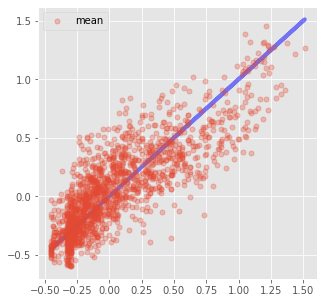

In [143]:
plt.figure(figsize=[5,5])
plt.plot(y_test.numpy(),y_test.numpy(),'b',lw=4,alpha=0.5)
plt.plot(y_test.numpy(),np.mean(y_preds_cat,axis=1),'o',ms=5,alpha=0.3,label='mean')

plt.legend()

In [44]:
for x_batch,y0_batch,y_batch in train_dl:
    x_batch, y0_batch, y_batch = x_batch.to(device), y0_batch.to(device), y_batch.to(device)
    

In [ ]:
train_epochs=[]
train_loss=[]
test_loss=[]
#     test_epochs=[]

# Training iterations:
for epoch in range(epochs):
    model.train()
    epoch_loss =0
    num_total = 0
    for x,y0, y in train_dl:
        # x= x.to(device)
        # y0= y0.to(device)
        # y= y.to(device)
        pred = model(x,y0)
        loss = loss_func(pred, y)

        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_loss+=len(x)*loss.item()
        num_total+=len(x)
    train_epochs.append(epoch)
    train_loss.append(epoch_loss/num_total)

    model.eval() # for validation
    with torch.no_grad():
        # save for plotting
        nums,losses = zip(*[[len(x), loss_func(
            model(x.to(device),y0.to(device)), y.to(device)).item() ]
                            for x,y0,y in test_dl])
        nums,losses = zip(*[ 
            [len(x), loss_func(model(x,y0, y)).item() ] for x,y0,y in test_dl ]
                         )
        test_loss.append(np.sum(np.multiply(nums,losses))/np.sum(nums))

        # print to terminal
    if epoch%(epochs//print_times)==0:
        print('epoch {}> train_loss: {}, test_loss: {}'.format(
            epoch,train_loss[-1],test_loss[-1]))
        #print(scheduler.get_lr()) # to verify lr
    if scheduler!=None:
        # change learning rate
        scheduler.step()

In [60]:


def train_model_dl(model,train_dl,test_dl,opt, loss_func,
                epochs=100, test_intervl=25, print_times=10, scheduler=None):
    '''
    Arg-s:
    - optim : optimizer/ solver
    - test_intervl: collect loss every "test_intervl" iter-n
    - print_times : number of times to print loss to the terminal
    - epochs : total number of training epochs == training iterations for the batch
    '''
    train_epochs=[]
    train_loss=[]
    test_loss=[]
    #     test_epochs=[]
    
    # Training iterations:
    for epoch in range(epochs):
        model.train()
        epoch_loss =0
        num_total = 0
        for x,y0, y in train_dl:
            # x= x.to(device)
            # y0= y0.to(device)
            # y= y.to(device)
            pred = model(x,y0)
            loss = loss_func(pred, y)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            epoch_loss+=len(x)*loss.item()
            num_total+=len(x)
        train_epochs.append(epoch)
        train_loss.append(epoch_loss/num_total)
        
        model.eval() # for validation
        with torch.no_grad():
            # save for plotting
            nums,losses = zip(*[[len(x), loss_func(
                model(x.to(device),y0.to(device)), y.to(device)).item() ]
                                for x,y0,y in test_dl])
            nums,losses = zip(*[ 
                [len(x), loss_func(model(x,y0, y)).item() ] for x,y0,y in test_dl ]
                             )
            test_loss.append(np.sum(np.multiply(nums,losses))/np.sum(nums))
            
            # print to terminal
        if epoch%(epochs//print_times)==0:
            print('epoch {}> train_loss: {}, test_loss: {}'.format(
                epoch,train_loss[-1],test_loss[-1]))
            #print(scheduler.get_lr()) # to verify lr
        if scheduler!=None:
            # change learning rate
            scheduler.step()
    return train_epochs, train_loss, test_loss


epoch 0> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 22> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 44> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 66> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 88> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 110> train_loss: 0.016547461971640587, test_loss: 0.055027157068252563
epoch 132> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 154> train_loss: 0.016547461971640587, test_loss: 0.055027157068252563
epoch 176> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265
epoch 198> train_loss: 0.016547461971640587, test_loss: 0.055027153342962265


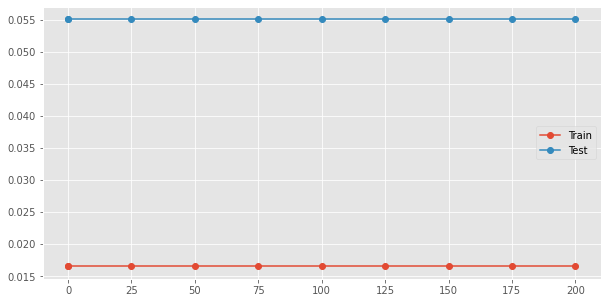

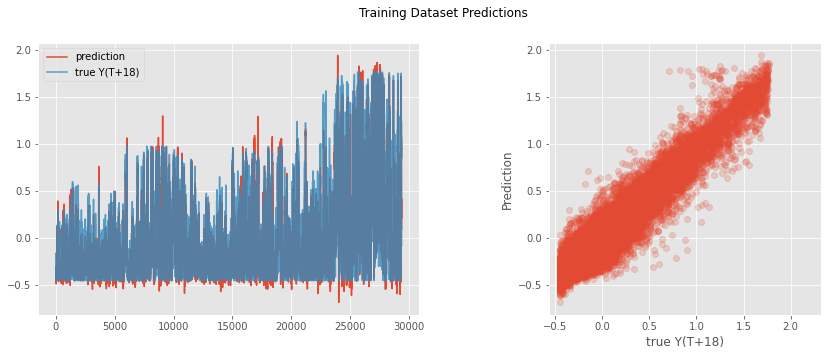

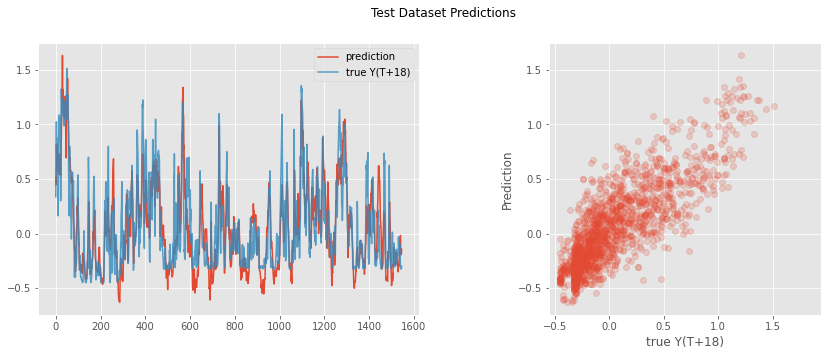

MSE loss (np): 0.055027157


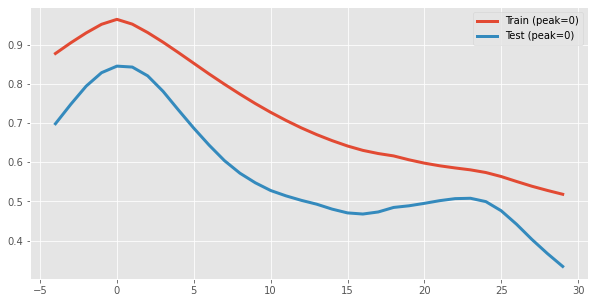

Train lag peak:0
Test lag peak:0


In [81]:

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
scheduler=None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test,label='prediction')
axs[0].plot(target_test,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')

In [83]:
# net.cpu()
# import pickle
# file_name = './best_models/_ver5.pkl'
# # Save
# with open(file_name, 'wb') as f:
#   pickle.dump(net, f)